In [1]:
pip install comet-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.8/586.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.7/514.7 kB 21.1 MB/s eta 0:00:00
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.7.0
    Uninstalling websocket-client-1.7.0:
      Successfully uninstalled websocket-client-1.7.0
  Attempting uninstall: python-box
    Found existing installation: python-box 7.1.1
    Uninstalling python-box-7.1.1:
      Successfully uninstalled python-box-7.1.1


### EDA

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from comet_ml import Experiment

# Function to fetch S&P 500 tickers and sectors
def get_sp500_tickers_and_sectors():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url, header=0)[0]
    return table[['Symbol', 'GICS Sector']].rename(columns={'Symbol': 'Ticker'})

# Function to fetch stock data
def fetch_stock_data(ticker, start_date, end_date):
    ticker = ticker.replace('.', '-')
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_date, end=end_date)
        hist.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
        hist['Return'] = hist['Close'] / hist['Close'].shift(1)
        hist.dropna(subset=['Return'], inplace=True)
        return hist
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame()

# Function to generate SP500 stock tables
def generate_sp500_stock_tables(start_date='2020-01-01', end_date='2023-12-05'):
    sp500_tickers_sectors = get_sp500_tickers_and_sectors()
    sp500_data = {}

    for ticker, sector in sp500_tickers_sectors.itertuples(index=False):
        stock_data = fetch_stock_data(ticker, start_date, end_date)
        stock_data['Sector'] = sector
        sp500_data[ticker] = stock_data

    return sp500_data

# Function to standardize the returns in each stock
def standardize_returns(stock_tables):
    scaler = StandardScaler()

    for ticker, df in stock_tables.items():
        if not df.empty and 'Return' in df.columns:
            # Reshape the data for standardization (needs to be 2D)
            returns = df['Return'].values.reshape(-1, 1)

            # Standardize the 'Return' feature
            standardized_returns = scaler.fit_transform(returns)

            # Replace the original 'Return' column with the standardized values
            df['Return'] = standardized_returns

    return stock_tables

# Get tables by sector
def get_tables_by_sector(stock_tables, target_sector):
    filtered_tables = {}
    for ticker, df in stock_tables.items():
        if not df.empty and 'Sector' in df.columns and df['Sector'].iloc[0] == target_sector:
            filtered_tables[ticker] = df
    return filtered_tables

# Generate the dataframe for each stock in S&P 500
sp500_stock_tables = generate_sp500_stock_tables()

# Standardize the returns in each stock
sp500_stock_tables_standardized = standardize_returns(sp500_stock_tables)

# Get the dataframe of stocks with 'Information Technology' Sector
it_sector_tables = get_tables_by_sector(sp500_stock_tables, 'Information Technology')

## Part One: Pairing

### PCA

In [3]:
from sklearn.decomposition import PCA

def perform_pca(stock_tables, n_components):
    # 1. Create a dataframe which contains the 'Return' of each stock
    returns_data = pd.DataFrame()

    for ticker, df in stock_tables.items():
        if not df.empty and 'Return' in df.columns:
            returns_data[ticker] = df['Return']

    # 2. Compute Covariance Matrix
    cov_matrix = returns_data.cov()

    # 3. Apply PCA with n_components
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(cov_matrix)

    # 4. Create a dataframe with the ticker name and n_components
    principal_components_df = pd.DataFrame(principal_components, index=cov_matrix.index)

    return principal_components_df

# Set n_components to 3 and pass in the stock dataframes in IT sector
n_components = 3
principal_components_df = perform_pca(it_sector_tables, n_components)
principal_components_df.tail(9)


,0,1,2
TEL,-0.500306,0.472857,0.025634
TDY,0.420111,0.363486,-0.011544
TER,-0.686810,0.081627,0.317854
TXN,-0.866983,0.133635,0.032290
TRMB,0.028173,0.157485,0.002013
TYL,0.215907,-0.575934,-0.101318
VRSN,0.001447,-0.394066,-0.383279
WDC,0.193941,0.585978,0.252621
ZBRA,-0.052833,0.074692,-0.103106


### OPTICS for Clustering

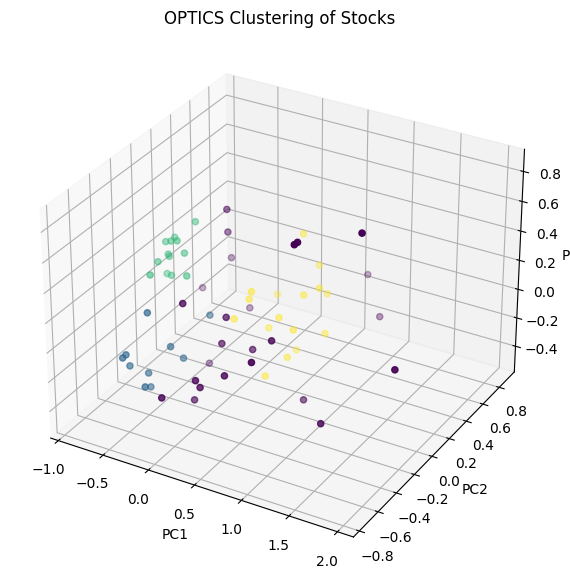

In [4]:
from sklearn.cluster import OPTICS
import matplotlib.pyplot as plt


def cluster_stocks_with_optics(principal_components_df, min_samples):
    # Apply OPTICS clustering algorithm
    optics = OPTICS(min_samples=min_samples)
    labels = optics.fit_predict(principal_components_df)

    # labeling
    principal_components_df['Cluster'] = labels

    # Plot
    if principal_components_df.shape[1] in [3, 4]:
        plt.figure(figsize=(10, 7))

        if principal_components_df.shape[1] == 4:
            ax = plt.axes(projection='3d')
            ax.scatter(principal_components_df.iloc[:, 0], principal_components_df.iloc[:, 1], principal_components_df.iloc[:, 2], c=labels, cmap='viridis', marker='o')
            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')
            ax.set_zlabel('PC3')
        else:
            plt.scatter(principal_components_df.iloc[:, 0], principal_components_df.iloc[:, 1], c=labels, cmap='viridis', marker='o')
            plt.xlabel('PC1')
            plt.ylabel('PC2')

        plt.title('OPTICS Clustering of Stocks')
        plt.show()

    return principal_components_df

min_samples = 5  # number of points in a neighborhood for a point to be considered as a core point
clustered_df = cluster_stocks_with_optics(principal_components_df, min_samples)

In [5]:
# Show each ticker in every cluster
def display_tickers_in_clusters(clustered_df):

    unique_clusters = clustered_df['Cluster'].unique()


    for cluster in unique_clusters:

        tickers_in_cluster = clustered_df[clustered_df['Cluster'] == cluster].index.tolist()

        print(f"Cluster {cluster}:")
        print(tickers_in_cluster)
        print("\n")


display_tickers_in_clusters(clustered_df)


Cluster -1:
['ACN', 'AMD', 'AKAM', 'APH', 'ANET', 'CDW', 'ENPH', 'EPAM', 'FICO', 'FSLR', 'FTNT', 'GEN', 'HPE', 'IBM', 'MU', 'ON', 'ORCL', 'PANW', 'PTC', 'CRM', 'NOW', 'SEDG', 'TEL', 'TYL', 'VRSN']


Cluster 0:
['ADBE', 'ANSS', 'AAPL', 'ADSK', 'CDNS', 'INTU', 'KEYS', 'MSFT', 'NVDA', 'SNPS']


Cluster 1:
['ADI', 'AMAT', 'AVGO', 'KLAC', 'LRCX', 'MCHP', 'MPWR', 'NXPI', 'QRVO', 'QCOM', 'SWKS', 'TER', 'TXN']


Cluster 2:
['CSCO', 'CTSH', 'GLW', 'FFIV', 'IT', 'HPQ', 'INTC', 'JNPR', 'MSI', 'NTAP', 'ROP', 'STX', 'TDY', 'TRMB', 'WDC', 'ZBRA']




In [6]:
def separate_clusters_to_lists(clustered_df):
    # Get clustering labels except -1
    unique_clusters = [cluster for cluster in clustered_df['Cluster'].unique() if cluster != -1]

    # Initialize a dictionary to store the tickers
    clusters_dict = {}

    # Go through every cluster and add the corresponding tickers to the list
    for cluster in unique_clusters:
        clusters_dict[cluster] = clustered_df[clustered_df['Cluster'] == cluster].index.tolist()

    return clusters_dict

# Build the cluster dictionary
clustered_lists_dict = separate_clusters_to_lists(clustered_df)



In [7]:
from statsmodels.tsa.stattools import adfuller, coint

def calculate_hurst_exponent(time_series):
    """Calculate hurst exponent for time series"""
    cumsum = np.cumsum(time_series - np.mean(time_series)).values  # transfer Series to Numpy
    time_spans = np.arange(2, len(time_series))
    rs_values = []

    for span in time_spans:
        length = len(cumsum) - len(cumsum) % span
        span_series = cumsum[:length]

        # use reshape
        span_series = span_series.reshape(-1, span)
        span_max = span_series.max(axis=1)
        span_min = span_series.min(axis=1)
        r = span_max - span_min
        s = np.std(span_series, axis=1)
        rs = np.mean(r / s)
        rs_values.append(rs)

    hurst_exponent = np.polyfit(np.log(time_spans), np.log(rs_values), 1)[0]
    return hurst_exponent



def find_cointegrated_pairs_for_clusters(clustered_lists_dict, it_sector_tables):
    results = {}

    for cluster, tickers in clustered_lists_dict.items():
        pairs = []
        for i in range(len(tickers)):
            for j in range(i+1, len(tickers)):
                ticker1, ticker2 = tickers[i], tickers[j]

                if ticker1 in it_sector_tables and ticker2 in it_sector_tables:
                    stock1 = it_sector_tables[ticker1]['Close']
                    stock2 = it_sector_tables[ticker2]['Close']

                    # Engle-Granger test
                    score, p_value, _ = coint(stock1, stock2)
                    if p_value < 0.05:
                        # Calculate the hurst exponent for price spread
                        hurst = calculate_hurst_exponent(stock1 - stock2)
                        if hurst < 0.5:
                            pairs.append((ticker1, ticker2))

        results[cluster] = pairs

    return results


cointegrated_pairs_clusters = find_cointegrated_pairs_for_clusters(clustered_lists_dict, it_sector_tables)

for cluster, pairs in cointegrated_pairs_clusters.items():
    print(f"Cluster {cluster} Pairs of stocks that are cointegrated and whose price differences exhibit mean-reverting behavior: {pairs}")

Cluster 0 Pairs of stocks that are cointegrated and whose price differences exhibit mean-reverting behavior: [('CDNS', 'SNPS')]
Cluster 1 Pairs of stocks that are cointegrated and whose price differences exhibit mean-reverting behavior: [('ADI', 'MCHP'), ('ADI', 'MPWR'), ('AMAT', 'NXPI'), ('LRCX', 'NXPI'), ('QRVO', 'SWKS')]
Cluster 2 Pairs of stocks that are cointegrated and whose price differences exhibit mean-reverting behavior: [('CSCO', 'TDY'), ('NTAP', 'TDY'), ('WDC', 'ZBRA')]


## Part Two: Trading

In [8]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, GRU
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os


def train_and_evaluate_model(ticker_pair):
    # collect the data and calculate spread
    stock1 = yf.download(ticker_pair[0], start='2020-01-01', end='2023-12-05')['Close']
    stock2 = yf.download(ticker_pair[1], start='2020-01-01', end='2023-12-05')['Close']
    price_difference = stock1 - stock2

    # Build slide window and set up the preprocess data
    look_back = 60
    price_difference_normalized = (price_difference - np.mean(price_difference)) / np.std(price_difference)
    X, y = preprocess_data(price_difference_normalized, look_back)

    # Build the model
    model = build_model((X.shape[1], 1))
    model.fit(X, y, epochs=100, batch_size=32)

    # Genereate Trading Signal
    predicted_price_diff = model.predict(X)
    actual_price_diff = price_difference_normalized[look_back:look_back+len(predicted_price_diff)]
    percentage_change = (predicted_price_diff[:-1].flatten() - actual_price_diff[:-1]) / actual_price_diff[:-1]

    upper_threshold = 0.3
    lower_threshold = -0.3
    signals = np.where(percentage_change > upper_threshold, 1, np.where(percentage_change < lower_threshold, -1, 0))

    # Back Tesing
    initial_cash = 10000
    asset_holdings = np.zeros_like(signals)
    cash = np.zeros_like(signals)
    cash[0] = initial_cash

    for t in range(1, len(signals)):
        asset_holdings[t] = asset_holdings[t-1] + signals[t-1]
        cash[t] = cash[t-1] - signals[t-1] * price_difference.values[look_back+t]

    portfolio_value = initial_cash + asset_holdings * price_difference.values[look_back:-1]

    # Evaluations
    final_return = portfolio_value[-1] - initial_cash
    peak = np.maximum.accumulate(portfolio_value)
    drawdown = (peak - portfolio_value) / peak
    max_drawdown = np.max(drawdown)
    portfolio_returns = np.diff(portfolio_value) / portfolio_value[:-1]
    sharpe_ratio = np.mean(portfolio_returns) / np.std(portfolio_returns)

    # Plot and save the plot
    sp500_data = yf.download('SPY', start='2020-01-01', end='2023-12-05')['Close']

    # Rescaled S&P 500 data
    sp500_scaled = sp500_data / sp500_data.iloc[0] * initial_cash

    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_value, label='Portfolio Value')
    plt.plot(sp500_scaled.values, label='S&P 500', alpha=0.7)
    plt.title(f'Portfolio Value Over Time for {ticker_pair[0]} and {ticker_pair[1]} VS S&P500')
    plt.xlabel('Time')
    plt.ylabel('Value in $')
    plt.legend()

    # Make sure the path of 'data' exists
    if not os.path.exists('data'):
      os.makedirs('data')
    plt.savefig(f'data/portfolio_{ticker_pair[0]}_{ticker_pair[1]}.png')
    plt.close()

    # return the results
    return {
        "Final Return": final_return,
        "Max Drawdown": max_drawdown,
        "Sharpe Ratio": sharpe_ratio
    }


def train_and_evaluate_model_v1(ticker_pair):
    # collect the data and calculate spread
    stock1 = yf.download(ticker_pair[0], start='2015-01-01', end='2023-12-05')['Close']
    stock2 = yf.download(ticker_pair[1], start='2015-01-01', end='2023-12-05')['Close']
    price_difference = stock1 - stock2

    # Normalize the price difference
    look_back = 60
    price_difference_normalized = (price_difference - np.mean(price_difference)) / np.std(price_difference)

    # Split the dataset into training, validation, and test sets
    train_size = int(len(price_difference_normalized) * 0.7)
    validation_size = int(len(price_difference_normalized) * 0.1)
    test_size = len(price_difference_normalized) - train_size - validation_size

    train_data = price_difference_normalized[:train_size]
    validation_data = price_difference_normalized[train_size:train_size + validation_size]
    test_data = price_difference_normalized[-test_size:]  # Adjusted to take the last 20%

    X_train, y_train = preprocess_data(train_data, look_back)
    X_val, y_val = preprocess_data(validation_data, look_back)
    X_test, y_test = preprocess_data(test_data, look_back)

    # Train the model
    model = build_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

    # Evaluate the model on the test set
    test_loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')

    # Generate Trading Signal
    predicted_price_diff = model.predict(X_test)
    actual_price_diff = test_data[look_back:look_back + len(predicted_price_diff)]
    percentage_change = (predicted_price_diff[:-1].flatten() - actual_price_diff[:-1]) / actual_price_diff[:-1]

    upper_threshold = 0.3
    lower_threshold = -0.3
    signals = np.where(percentage_change > upper_threshold, 1, np.where(percentage_change < lower_threshold, -1, 0))

    # Back Testing
    initial_cash = 10000
    asset_holdings = np.zeros_like(signals)
    cash = np.zeros_like(signals)
    cash[0] = initial_cash

    # Adjust the loop to align with the length of the test data
    for t in range(1, len(signals)):
        if t < len(test_data.values) - look_back:
            asset_holdings[t] = asset_holdings[t-1] + signals[t-1]
            cash[t] = cash[t-1] - signals[t-1] * test_data.values[t + look_back - 1]

    portfolio_value = initial_cash + asset_holdings * test_data.values[look_back:-1]

    # Evaluations
    final_return = portfolio_value[-1] - initial_cash
    peak = np.maximum.accumulate(portfolio_value)
    drawdown = (peak - portfolio_value) / peak
    max_drawdown = np.max(drawdown)
    portfolio_returns = np.diff(portfolio_value) / portfolio_value[:-1]
    sharpe_ratio = np.mean(portfolio_returns) / np.std(portfolio_returns)

    # Plot and save the plot
    sp500_data = yf.download('SPY', start='2020-01-01', end='2023-12-05')['Close']

    # Rescaled S&P 500 data
    sp500_scaled = sp500_data / sp500_data.iloc[0] * initial_cash

    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_value, label='Portfolio Value')
    plt.plot(sp500_scaled.values, label='S&P 500', alpha=0.7)
    plt.title(f'Portfolio Value Over Time for {ticker_pair[0]} and {ticker_pair[1]} VS S&P500')
    plt.xlabel('Time')
    plt.ylabel('Value in $')
    plt.legend()

    # Make sure the path of 'data' exists
    if not os.path.exists('data'):
        os.makedirs('data')
    plt.savefig(f'data/portfolio_{ticker_pair[0]}_{ticker_pair[1]}.png')
    plt.close()

    # return the results
    return {
        "Final Return": final_return,
        "Max Drawdown": max_drawdown,
        "Sharpe Ratio": sharpe_ratio,
        "Test Loss": test_loss
    }


# function to preprocess the data
def preprocess_data(price_diff, look_back=60):
    X, y = [], []
    for i in range(look_back, len(price_diff)):
        X.append(price_diff[i-look_back:i])
        y.append(price_diff[i])
    return np.array(X), np.array(y)

# Build the LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
    return model


# Build the GRU model
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(GRU(units=70, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(GRU(units=30))
    model.add(Dropout(0.2))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
    return model

# Build a Bi-directional LSTM model
def build_bidirectional_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=50)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
    return model



# Save every pair of stock
all_results = []

# Go through every pair of stocks in cointegrated_pairs_clusters
for cluster, pairs in cointegrated_pairs_clusters.items():
    for ticker_pair in pairs:

        # apply train_and_evaluate_model function on every pair of stocks
        # also add comet-ml experiments to track the metrics
        exp = Experiment(api_key="e2r17h4Vlyi4xN3MMdwiSvRgN",
                         project_name="pair-trading",
                         workspace="charlie-hou",)

        result = train_and_evaluate_model(ticker_pair)

        metrics = {
            "Final Return": result['Final Return'],
            "Max Drawdown": result['Max Drawdown'],
            "Sharpe Ratio": result['Sharpe Ratio']
        }

        exp.log_metrics(metrics)
        exp.end()


        # add the result to the list
        all_results.append({'pair': ticker_pair, 'results': result})

# Show the results
for item in all_results:
    print(f"Results for Ticker Pair {item['pair']}:")
    print(f"Final Return: {item['results']['Final Return']}")
    print(f"Max Drawdown: {item['results']['Max Drawdown']}")
    print(f"Sharpe Ratio: {item['results']['Sharpe Ratio']}")
    print("\n")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/charlie-hou/pair-trading/10b49b62edc341ee932573b404c785b2



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/100
29/29 [==============================] - 5s 9ms/step - loss: 0.1957
Epoch 2/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0598
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0448
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0385
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0341
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0346
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0333
Epoch 8/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0314
Epoch 9/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0285
Epoch 10/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0265
Epoch 11/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0277
Epoch 12/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0275
Epoch 13/100
29/29 [=================

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/charlie-hou/pair-trading/10b49b62edc341ee932573b404c785b2
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Final Return         : 3031.710174560547
COMET INFO:     Max Drawdown         : 0.15069118311763174
COMET INFO:     Sharpe Ratio         : 0.04931896580574817
COMET INFO:     batch_loss [300]     : (0.006125848274677992, 0.5739995241165161)
COMET INFO:     epoch_duration [100] : (0.1835760490000098, 5.067298886999993)
COMET INFO:     loss [100]           : (0.013089089654386044, 0.19571146368980408)
COMET INFO:   Others:
COMET INFO:     trainable_params : 30651
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
29/29 [==============================] - 3s 9ms/step - loss: 0.2577
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0791
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0610
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0568
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0543
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0527
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0455
Epoch 8/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0483
Epoch 9/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0477
Epoch 10/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0440
Epoch 11/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0447
Epoch 12/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0430
Epoch 13/100
29/29 [=================

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/charlie-hou/pair-trading/46b3a35c3b9f4675b293de10861b1211
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Final Return         : 393.6400146484375
COMET INFO:     Max Drawdown         : 0.10803063699628605
COMET INFO:     Sharpe Ratio         : 0.012880634620990395
COMET INFO:     batch_loss [300]     : (0.010748660191893578, 0.8191328048706055)
COMET INFO:     epoch_duration [100] : (0.18627071899999237, 2.8911771539999904)
COMET INFO:     loss [100]           : (0.020976178348064423, 0.2576692998409271)
COMET INFO:   Others:
COMET INFO:     trainable_params : 30651
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgr

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
29/29 [==============================] - 3s 9ms/step - loss: 0.2083
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0778
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0653
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0585
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0562
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0492
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0470
Epoch 8/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0477
Epoch 9/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0457
Epoch 10/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0424
Epoch 11/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0402
Epoch 12/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0391
Epoch 13/100
29/29 [=================

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/charlie-hou/pair-trading/d4159efa8f804089958dc4cd3451bb9f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Final Return         : -1506.159912109375
COMET INFO:     Max Drawdown         : 0.40483065539189966
COMET INFO:     Sharpe Ratio         : -0.008715436240318878
COMET INFO:     batch_loss [300]     : (0.009916037321090698, 0.6589096784591675)
COMET INFO:     epoch_duration [100] : (0.1891844810000407, 3.18627312000001)
COMET INFO:     loss [100]           : (0.021138019859790802, 0.20833192765712738)
COMET INFO:   Others:
COMET INFO:     trainable_params : 30651
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgr

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
29/29 [==============================] - 3s 9ms/step - loss: 0.4291
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.2252
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1923
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1798
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1663
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1517
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1439
Epoch 8/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1379
Epoch 9/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1297
Epoch 10/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1241
Epoch 11/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1186
Epoch 12/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1181
Epoch 13/100
29/29 [=================

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/charlie-hou/pair-trading/87bc71044bb34980b079da6f2591f4c2
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Final Return         : 3894.479736328125
COMET INFO:     Max Drawdown         : 0.18443995009179676
COMET INFO:     Sharpe Ratio         : 0.047892312064337035
COMET INFO:     batch_loss [300]     : (0.034447088837623596, 0.7271287441253662)
COMET INFO:     epoch_duration [100] : (0.1904301000000146, 2.853164829000036)
COMET INFO:     loss [100]           : (0.0730280950665474, 0.42912641167640686)
COMET INFO:   Others:
COMET INFO:     trainable_params : 30651
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
29/29 [==============================] - 3s 10ms/step - loss: 0.1659
Epoch 2/100
29/29 [==============================] - 0s 8ms/step - loss: 0.0791
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0623
Epoch 4/100
29/29 [==============================] - 0s 8ms/step - loss: 0.0573
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0530
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0515
Epoch 7/100
29/29 [==============================] - 0s 8ms/step - loss: 0.0476
Epoch 8/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0437
Epoch 9/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0418
Epoch 10/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0400
Epoch 11/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0397
Epoch 12/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0365
Epoch 13/100
29/29 [================

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/charlie-hou/pair-trading/26a99acd6ae7494b847bc201dc393cf3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Final Return         : -6196.80029296875
COMET INFO:     Max Drawdown         : 0.7271526818596292
COMET INFO:     Sharpe Ratio         : -0.034699679810868606
COMET INFO:     batch_loss [300]     : (0.009790911339223385, 0.6026881337165833)
COMET INFO:     epoch_duration [100] : (0.1905569130000231, 2.980551380999998)
COMET INFO:     loss [100]           : (0.019107796251773834, 0.16586224734783173)
COMET INFO:   Others:
COMET INFO:     trainable_params : 30651
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgra

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
29/29 [==============================] - 3s 9ms/step - loss: 0.4111
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1965
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1564
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1316
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1193
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1035
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0974
Epoch 8/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0936
Epoch 9/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0904
Epoch 10/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0850
Epoch 11/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0836
Epoch 12/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0799
Epoch 13/100
29/29 [=================

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/charlie-hou/pair-trading/69a35432be364f45afa3b1d2a7e18bf0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Final Return         : 14.630081176757812
COMET INFO:     Max Drawdown         : 0.030762571923390793
COMET INFO:     Sharpe Ratio         : 0.0018197164463167948
COMET INFO:     batch_loss [300]     : (0.011927569285035133, 0.9118970036506653)
COMET INFO:     epoch_duration [100] : (0.19179220100005523, 2.960972507000008)
COMET INFO:     loss [100]           : (0.04722253978252411, 0.41107863187789917)
COMET INFO:   Others:
COMET INFO:     trainable_params : 30651
COMET INFO:   Parameters:
COMET INFO:     Adam_ams

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
29/29 [==============================] - 3s 9ms/step - loss: 0.3490
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1279
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1010
Epoch 4/100
29/29 [==============================] - 0s 8ms/step - loss: 0.0929
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0810
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0727
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0714
Epoch 8/100
29/29 [==============================] - 0s 8ms/step - loss: 0.0685
Epoch 9/100
29/29 [==============================] - 0s 8ms/step - loss: 0.0641
Epoch 10/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0599
Epoch 11/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0572
Epoch 12/100
29/29 [==============================] - 0s 8ms/step - loss: 0.0600
Epoch 13/100
29/29 [=================

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/charlie-hou/pair-trading/13d7142826aa475888251c3ee4dea7c1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Final Return         : 0.0
COMET INFO:     Max Drawdown         : 0.42429699680288363
COMET INFO:     Sharpe Ratio         : 0.009708498920377036
COMET INFO:     batch_loss [300]     : (0.01300047617405653, 1.078871726989746)
COMET INFO:     epoch_duration [100] : (0.19256475999998202, 2.897907809000003)
COMET INFO:     loss [100]           : (0.030725931748747826, 0.34899166226387024)
COMET INFO:   Others:
COMET INFO:     trainable_params : 30651
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad              

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
29/29 [==============================] - 3s 9ms/step - loss: 0.3107
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1557
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1349
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1150
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.1027
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0993
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0974
Epoch 8/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0838
Epoch 9/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0824
Epoch 10/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0757
Epoch 11/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0737
Epoch 12/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0669
Epoch 13/100
29/29 [=================

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/charlie-hou/pair-trading/015c2a37db5a42daaa56f05a15d31ce6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Final Return         : 13980.5595703125
COMET INFO:     Max Drawdown         : 0.30714022930120355
COMET INFO:     Sharpe Ratio         : 0.0751332595692398
COMET INFO:     batch_loss [300]     : (0.018338490277528763, 1.013750672340393)
COMET INFO:     epoch_duration [100] : (0.18839992400000938, 2.9504049230000646)
COMET INFO:     loss [100]           : (0.03977465257048607, 0.31067660450935364)
COMET INFO:   Others:
COMET INFO:     trainable_params : 30651
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad  

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
29/29 [==============================] - 3s 9ms/step - loss: 0.1904
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0477
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0358
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0308
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0306
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0303
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0288
Epoch 8/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0264
Epoch 9/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0231
Epoch 10/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0250
Epoch 11/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0256
Epoch 12/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0250
Epoch 13/100
29/29 [=================

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/charlie-hou/pair-trading/a717f63b8dbf4a70bdf8e30a96b5356b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Final Return         : 1928.3000183105469
COMET INFO:     Max Drawdown         : 0.22724675896898025
COMET INFO:     Sharpe Ratio         : 0.026116184091080612
COMET INFO:     batch_loss [300]     : (0.007150992751121521, 1.0754748582839966)
COMET INFO:     epoch_duration [100] : (0.1891137920000574, 2.8876982429999316)
COMET INFO:     loss [100]           : (0.011948703788220882, 0.19040927290916443)
COMET INFO:   Others:
COMET INFO:     trainable_params : 30651
COMET INFO:   Parameters:
COMET INFO:     Adam_amsg

Results for Ticker Pair ('CDNS', 'SNPS'):
Final Return: 3031.710174560547
Max Drawdown: 0.15069118311763174
Sharpe Ratio: 0.04931896580574817


Results for Ticker Pair ('ADI', 'MCHP'):
Final Return: 393.6400146484375
Max Drawdown: 0.10803063699628605
Sharpe Ratio: 0.012880634620990395


Results for Ticker Pair ('ADI', 'MPWR'):
Final Return: -1506.159912109375
Max Drawdown: 0.40483065539189966
Sharpe Ratio: -0.008715436240318878


Results for Ticker Pair ('AMAT', 'NXPI'):
Final Return: 3894.479736328125
Max Drawdown: 0.18443995009179676
Sharpe Ratio: 0.047892312064337035


Results for Ticker Pair ('LRCX', 'NXPI'):
Final Return: -6196.80029296875
Max Drawdown: 0.7271526818596292
Sharpe Ratio: -0.034699679810868606


Results for Ticker Pair ('QRVO', 'SWKS'):
Final Return: 14.630081176757812
Max Drawdown: 0.030762571923390793
Sharpe Ratio: 0.0018197164463167948


Results for Ticker Pair ('CSCO', 'TDY'):
Final Return: 0.0
Max Drawdown: 0.42429699680288363
Sharpe Ratio: 0.009708498920377036
